<a href="https://colab.research.google.com/github/DrakeData/NLP-Disaster_Tweets/blob/main/NLP_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Disaster Tweets

In [207]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import random
import os
import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import accuracy_score
from keras.callbacks import CSVLogger
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU
from keras.layers import Dense, Embedding, Bidirectional, Dropout, Flatten
from nltk.stem import SnowballStemmer
import re

## Ingest
Donwloading the data from Kaggle's API

In [55]:
! pip install kaggle

In [56]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [57]:
! cp './drive/MyDrive/Colab Notebooks/API Keys/kaggle.json' ~/.kaggle/

In [58]:
! chmod 600 ~/.kaggle/kaggle.json

In [59]:
! kaggle competitions download nlp-getting-started

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


In [60]:
! wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-03-05 22:50:56--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-05 22:50:57--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-05 22:50:57--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [61]:
! unzip glove*.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [62]:
train_df = pd.read_csv('train.csv')

test_df = pd.read_csv('test.csv')

## EDA

In [63]:
# Look at random sample of 10
train_df.sample(10)

,id,keyword,location,text,target
3626,5175,fatalities,#WashingtonState #Seattle,#Seattle's deadliest red light runner intersec...,1
7060,10114,upheaval,Jamaica,Series finale of #TheGame :( It survived so mu...,0
2692,3861,detonation,NaN,Ignition Knock (Detonation) Sensor-Senso Stand...,1
920,1332,blown%20up,L/S/Z/L/T/H/C/H/R/A/S/C,@Papcrdoll and I s2g if my mentions get blown ...,0
5189,7408,obliterated,#freegucci,Me- Don't bother calling or texting me because...,0
49,71,ablaze,England.,First night with retainers in. It's quite weir...,0
1928,2771,curfew,NaN,@aptly_engineerd There is no such curfew.,0
5618,8016,refugees,paradise,#retweet Cameroon repatriating about 12000 Nig...,1
2737,3935,devastated,Banbridge,'Er indoors will be devastated. RIP Arfur. #Ge...,1
2489,3573,desolate,NaN,Daniel 12:11 And from the time that the daily...,0


Column notes:
- id: tweet unique identifier
- keyword: keyword from the tweet; can return blank
- location: location that the tweet was sent from; can return blank
- text: text from tweet
- target: labels the tweet if the tweet is about a real disaster (1) or not (0)

In [64]:
# Check shape of data sets
print(f"Train data set shape: {train_df.shape}")
print(f"Test data set shape: {test_df.shape}")

Train data set shape: (7613, 5)
Test data set shape: (3263, 4)


In [65]:
# Check missing values
print(f"Train Dataset missing data: \n{train_df.isnull().sum()}\n")
print(f"Test Dataset missing data: \n{test_df.isnull().sum()}")

Train Dataset missing data: 
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Test Dataset missing data: 
id             0
keyword       26
location    1105
text           0
dtype: int64


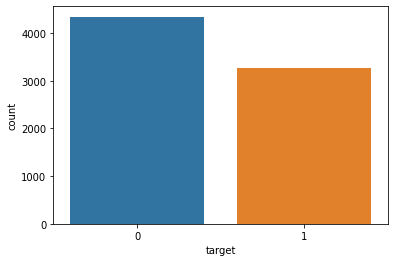

In [66]:
sns.countplot(x='target', data=train_df);

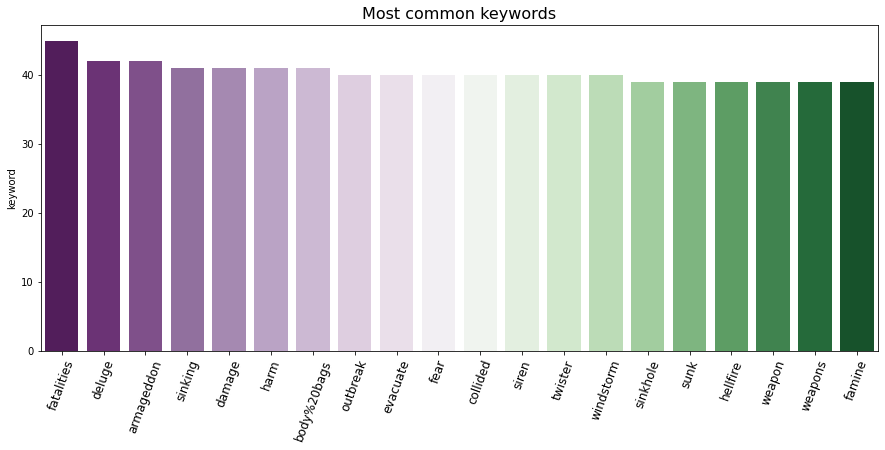

In [67]:
# Check key words
keywords_check = train_df["keyword"].value_counts()[:20].to_frame()

fig = plt.figure(figsize=(15,6))
sns.barplot(data=keywords_check, x=keywords_check.index, y="keyword", palette="PRGn")
plt.title("Most common keywords",size=16)
plt.xticks(rotation=70,size=12);

### Preprocessing
- Make all text lowercase
- Remove special characters
- Remove numbers 
- Remove stop words
- Remove extra spacing (whitespace)
- Remove weblinks
- Expand contractions when possible
- Tokenize


In [68]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [69]:
def remove_emoji(string):
  '''
  Remove emojies from text
  '''
  emoji_pattern = re.compile("["
  u"\U0001F600-\U0001F64F"
  u"\U0001F300-\U0001F5FF"
  u"\U0001F680-\U0001F6FF"
  u"\U0001F1E0-\U0001F1FF"
  u"\U00002702-\U000027B0"
  u"\U000024C2-\U0001F251"
  u"\U0001f926-\U0001f937"
  u'\U00010000-\U0010ffff'
  u"\u200d"
  u"\u2640-\u2642"
  u"\u2600-\u2B55"
  u"\u23cf"
  u"\u23e9"
  u"\u231a"
  u"\u3030"
  u"\ufe0f"
  "]+", flags=re.UNICODE)
  
  return emoji_pattern.sub(r' ', string)

In [126]:
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english') 

def preprocess(sentence):
  # dtype to string
  sentence=str(sentence)
  # lowercase
  sentence = sentence.lower()
  # remove html links
  sentence = sentence.replace('{html}',"")
  # remove emojies
  sentence = remove_emoji(sentence)
  # remove special characters
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', sentence)
  # remove urls
  rem_url=re.sub(r'http\S+', '',cleantext)
  # remove numbers
  rem_num = re.sub('[0-9]+', '', rem_url)

  # tokenize text
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_num)

  # remove stopwords  
  filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
  stem_words=[stemmer.stem(w) for w in filtered_words]
  lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
  
  return " ".join(filtered_words)

text_ls = ['keyword', 'location', 'text']


# Clean train_df
for col in text_ls:
  for i in range(len(train_df[col])):
    train_df[col][i] = preprocess(train_df[col][i])

# Clean test_df
for col in text_ls:
  for i in range(len(test_df[col])):
    test_df[col][i] = preprocess(test_df[col][i])

print("\nTrain Set:")
train_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Train Set:


,id,keyword,location,text,target
0,1,nan,nan,deeds reason earthquake may allah forgive,1
1,4,nan,nan,forest fire near ronge sask canada,1
2,5,nan,nan,residents asked shelter place notified officer...,1
3,6,nan,nan,people receive wildfires evacuation orders cal...,1
4,7,nan,nan,got sent photo ruby alaska smoke wildfires pou...,1


In [127]:
train_df.sample(10)

,id,keyword,location,text,target
553,802,battle,nan,baaaack petersen bowhunting battle bows make s...,0
1984,2855,damage,cheshire london allover,unions say supportive london yet prepared dama...,0
2797,4024,disaster,nan,vitaly churkin briliantly exposes hypocrisy uk...,1
4695,6675,landslide,dundee,dundee news army veteran fears loose rocks dun...,1
3271,4696,engulfed,london,tube strike live latest travel updates london ...,1
4242,6027,hazardous,portland,hazard hazardous condition fwy terwilliger blv...,1
6016,8591,screams,texas,screams mother,0
122,175,aftershock,nan,moment get scary roller coaster guy behind scr...,0
6160,8786,siren,flipadelphia,soonermagic_ mean fan need girl sounding like ...,1
3264,4689,engulfed,usa,car engulfed flames backs traffic parley ûªs s...,1


### Text encoding

In [128]:
def define_tokenizer(train_sentences, val_sentences, test_sentences):
    sentences = pd.concat([train_sentences, val_sentences, test_sentences])
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(sentences)
    
    return tokenizer
    
def encode(sentences, tokenizer):
    encoded_sentences = tokenizer.texts_to_sequences(sentences)
    encoded_sentences = tf.keras.preprocessing.sequence.pad_sequences(encoded_sentences, padding='post')
    
    return encoded_sentences

In [132]:
val_data = train_df.tail(1500)
train_data = train_df.head(6113)
test_data = test_df

In [133]:
tokenizer = define_tokenizer(train_data['text'], val_data['text'], test_data['text'])

encoded_sentences = encode(train_data['text'], tokenizer)
val_encoded_sentences = encode(val_data['text'], tokenizer)
encoded_test_sentences = encode(test_data['text'], tokenizer)

In [134]:
tokenizer.word_index['disaster']

12

In [135]:
len(tokenizer.word_index)

19999

In [136]:
print(f"Lower: {tokenizer.get_config()['lower']}")
print(f"Split: {tokenizer.get_config()['split']}")
print(f"Filters: {tokenizer.get_config()['filters']}")

Lower: True
Split:  
Filters: !"#$%&()*+,-./:;<=>?@[\]^_`{|}~	



### Use GloVe Embedding
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. Documentation can be [found here](https://nlp.stanford.edu/projects/glove/).

In [137]:
embedding_dict = {}

with open('./glove.6B.100d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
        
f.close()

In [138]:
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in tokenizer.word_index.items():
    if i > num_words:
        continue
    
    emb_vec = embedding_dict.get(word)
    
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

## Modeling

### Setup pipeline
We will create a pipeline that:
- Shuffle the data per training step
- Process the next batch of data for training while the current batch of data is training
- Defining each batch as a padded batch

In [139]:
tf_data = tf.data.Dataset.from_tensor_slices((encoded_sentences, train_data['target'].values))

def pipeline(tf_data, buffer_size=100, batch_size=32):
    tf_data = tf_data.shuffle(buffer_size)    
    tf_data = tf_data.prefetch(tf.data.experimental.AUTOTUNE)
    tf_data = tf_data.padded_batch(batch_size, padded_shapes=([None],[]))
    
    return tf_data

tf_data = pipeline(tf_data, buffer_size=1000, batch_size=32)

In [140]:
print(tf_data)

<PaddedBatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [141]:
# create pipeline for validation set
tf_val_data = tf.data.Dataset.from_tensor_slices((val_encoded_sentences, val_data['target'].values))

def val_pipeline(tf_data, batch_size=1):        
    tf_data = tf_data.prefetch(tf.data.experimental.AUTOTUNE)
    tf_data = tf_data.padded_batch(batch_size, padded_shapes=([None],[]))
    
    return tf_data

tf_val_data = val_pipeline(tf_val_data, batch_size=len(val_data))

In [142]:
print(tf_val_data)

<PaddedBatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


### Train model

In [143]:
embedding = tf.keras.layers.Embedding(
    len(tokenizer.word_index) + 1,
    100,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = True
)

In [144]:
model = tf.keras.Sequential([
    embedding,
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [145]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy', 'Precision', 'Recall']
)

In [146]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

In [147]:
history = model.fit(
    tf_data, 
    validation_data = tf_val_data,
    epochs = 50,
    callbacks = callbacks
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


192/192 [==============================] - 38s 161ms/step - loss: 0.5735 - accuracy: 0.7248 - precision: 0.7431 - recall: 0.5265 - val_loss: 0.4317 - val_accuracy: 0.8033 - val_precision: 0.8254 - val_recall: 0.7376 - lr: 1.0000e-04
Epoch 2/50
192/192 [==============================] - 30s 158ms/step - loss: 0.4628 - accuracy: 0.7906 - precision: 0.7977 - recall: 0.6715 - val_loss: 0.4197 - val_accuracy: 0.8107 - val_precision: 0.8165 - val_recall: 0.7702 - lr: 1.0000e-04
Epoch 3/50
192/192 [==============================] - 31s 159ms/step - loss: 0.4473 - accuracy: 0.7973 - precision: 0.8031 - recall: 0.6851 - val_loss: 0.4129 - val_accuracy: 0.8140 - val_precision: 0.8492 - val_recall: 0.7348 - lr: 1.0000e-04
Epoch 4/50
192/192 [==============================] - 31s 159ms/step - loss: 0.4372 - accuracy: 0.8037 - precision: 0.8165 - recall: 0.6867 - val_loss: 0.4114 - val_accuracy: 0.8093 - val_precision: 0.8189 - val_recall: 0.7631 - lr: 1.0000e-04
Epoch 5/50
192/192 [===============

In [219]:
metrics = model.evaluate(tf_val_data)
# print(model.metrics_names)


precision = metrics[2]
recall = metrics[3]
f1 = 2 * (precision * recall) / (precision + recall)

print(f'Accuracy score: {metrics[1]}')
print(f'F1 score: {str(f1)}') 

1/1 [==============================] - 1s 590ms/step - loss: 0.5822 - accuracy: 0.7780 - precision: 0.7467 - recall: 0.7986
Accuracy score: 0.777999997138977
F1 score: 0.7717614831744717


In [153]:
data = {'loss': history.history['loss'],
        'accuracy':  history.history['accuracy'],
        'precision': history.history['precision'],
        'recall': history.history['recall'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy']
        }

hist_df = pd.DataFrame(data)

hist_df.head()

,loss,accuracy,precision,recall,val_loss,val_accuracy
0,0.573515,0.724849,0.743124,0.526500,0.431696,0.803333
1,0.462765,0.790610,0.797685,0.671473,0.419701,0.810667
2,0.447268,0.797317,0.803106,0.685113,0.412946,0.814000
3,0.437176,0.803697,0.816497,0.686672,0.411430,0.809333
4,0.426269,0.812040,0.822485,0.704209,0.412314,0.812000


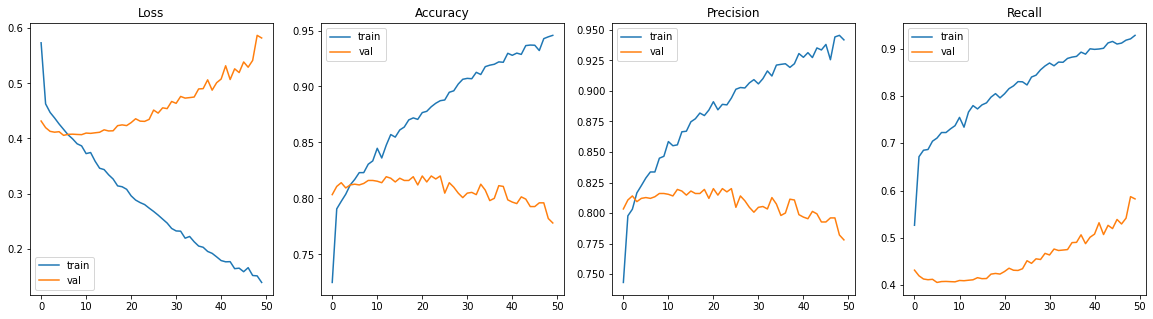

In [154]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].set_title('Loss')
axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='val')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(history.history['accuracy'], label='train')
axs[1].plot(history.history['val_accuracy'], label='val')
axs[1].legend()

axs[2].set_title('Precision')
axs[2].plot(history.history['precision'], label='train')
axs[2].plot(history.history['val_accuracy'], label='val')
axs[2].legend()

axs[3].set_title('Recall')
axs[3].plot(history.history['recall'], label='train')
axs[3].plot(history.history['val_loss'], label='val')
axs[3].legend()

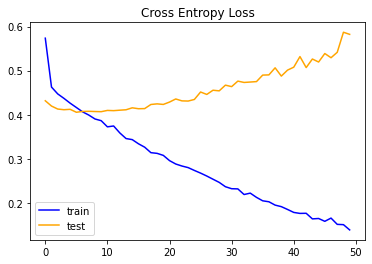

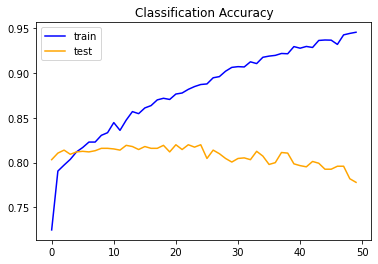

In [155]:
# plot loss
pyplot.title('Cross Entropy Loss')
pyplot.plot(hist_df['loss'], color='blue', label='train')
pyplot.plot(hist_df['val_loss'], color='orange', label='test')
pyplot.legend()
pyplot.show()

# plot accuracy
pyplot.title('Classification Accuracy')
pyplot.plot(hist_df['accuracy'], color='blue', label='train')
pyplot.plot(hist_df['val_accuracy'], color='orange', label='test')
pyplot.legend()
pyplot.show()

In [201]:
# Check for number of false positives
predictions = model.predict(tf_val_data)
predictions = np.concatenate(predictions).round().astype(int)
val_data['predictions'] = predictions

false_positives = val_data[(val_data['predictions'] == 1) & (val_data['target'] == 0)]

print(f'Count of false positives: {str(len(false_positives))}\n\n')

Count of false positives: 191




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [202]:
# Look at false positives
false_positives.head(10)

,id,keyword,location,text,target,predictions
6121,8737,sinking,london,slowly sinking wasting edsheeran,0,1
6159,8785,siren,nan,outdoor siren test fgcu siren tested today ano...,0,1
6161,8787,siren,nan,hate damn milwaukee indyfest cars sound like r...,0,1
6168,8797,sirens,canada,raychielovesu block hear sirens amp stories ki...,0,1
6186,8831,sirens,los angles,going hollywood abceyewitness abc helicopters ...,0,1
6217,8871,smoke,nan,trynna smoke hoe,0,1
6227,8888,smoke,indonesia,teamatowinner mean mino said smoke mention,0,1
6231,8896,snowstorm,nan,yall poem called one snowstorm meet space one ...,0,1
6233,8900,snowstorm,huntington,sorry built fire desk already irishirr mchapma...,0,1
6240,8912,snowstorm,south usa,sassy city girl country hunk stranded smoky mo...,0,1


In [203]:
# Check for number of false negatives
false_negatives = val_data[(val_data['predictions'] == 0) & (val_data['target'] == 1)]

print(f'Count of false negatives: {str(len(false_negatives))}')

Count of false negatives: 142


In [204]:
# Look at false negatives
false_positives.tail(10)

,id,keyword,location,text,target,predictions
7459,10675,wounds,north carolina,court back session testimony continues med exa...,0,1
7467,10684,wounds,charlotte,says many wounds could fatal rather quickly ot...,0,1
7472,10689,wreck,nan,wreck wreck wreck wreck wreck wreck wreck wrec...,0,1
7476,10693,wreck,pratt wye,many cars cyclists wreck going past scratching...,0,1
7487,10709,wreck,nan,emotions train wreck body train wreck wreck,0,1
7497,10724,wreck,innsmouth mass,staged locomotive wreck could possibly wrong,0,1
7548,10789,wrecked,pennsylvania,four hundred wrecked cars costing apiece purch...,0,1
7551,10794,wrecked,nan,freeway africa til wrecked audi,0,1
7579,10831,wrecked,vancouver canada,three days work pretty much wrecked hahaha sho...,0,1
7581,10833,wrecked,lincoln,engineshed great atmosphere british lion gig t...,0,1


### Make prediction

In [210]:
tf_test_data = tf.data.Dataset.from_tensor_slices((encoded_test_sentences))

def test_pipeline(tf_data, batch_size=1):        
    tf_data = tf_data.prefetch(tf.data.experimental.AUTOTUNE)
    tf_data = tf_data.padded_batch(batch_size, padded_shapes=([None]))
    
    return tf_data

tf_test_data = test_pipeline(tf_test_data)

In [213]:
pred = model.predict(tf_test_data)

In [214]:
pred = np.concatenate(pred).round().astype(int)

In [215]:
sub = pd.DataFrame(data={'target': pred}, index=test_data['id'])
sub.index = sub.index.rename('id')
sub.to_csv('drive/MyDrive/Colab Notebooks/NLP_Disaster_Tweets/submission1.csv')